# Team Viviane Solomon and Brandon Bonifacio

# HW6: Life Cycle of ML Model

Your goal is to develop a CNN model that, given a cell phone image
taken somewhere inside a building on HMC campus, can identify which building is being
photographed. You may use any online resources that you find helpful, but you must cite your
sources and indicate clearly what portions of your code have been copied and modified from
elsewhere. You may work individually or with a partner on this assignment. Please submit your
assignment as a single jupyter notebook on Sakai. If you work with a partner, make sure to
indicate both partners’ names clearly at the very top of your notebook.

## Part 1: Data Collection/Preparation

In the first part of the assignment, you will do the following:


• Data Collection (15 points). Each student/team will collect 50 cell phone pictures taken
of random locations inside a single building on campus. Please sign up for a building to
photograph in this spreadsheet, and upload your pictures to this shared google drive.
Since the data will be used by the entire class, please complete this portion of the
assignment by Saturday 1pm (-5 points if not done by then). If there are more than 5
buildings represented in the class data, you may simply select 5 buildings to use for this
assignment.


• Data Preparation (15 points). Download the class data onto your laptop. Prepare the
data for use in PyTorch by ensuring image format compatibility, putting the images in a
suitable directory structure, and creating train & validation partitions. Describe your
data preparation process in your notebook.

In [18]:
#Import Statements
import numpy as np
import math
import matplotlib.pyplot as plt
import torchvision
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split
import torch.nn as nn
import torchvision.models as models
from tqdm import tqdm
import torch.optim as optim

### In the cells below, we prepare the data for use in PyTorch by ensuring image format compatiblity, putting the images in a suitable directory structure, and creating train & validation partitions. We describe our data preparation process in the markdown cell below, and then encode it after that. 

### Our data preparation process is as follows. We first resize each image to 256 x 256 pixels to make all images compatible with the input of the ResNet model. Although ResNet will automatically resize different sized images, we felt it was better if we did it ourselves just for consistency's sake. We also convert each image into a Tensor so that we can use it with the super useful Dataloader object. 

### We used a train/val split of 0.3 because we wanted most of the data to be used for training, but we also wanted a large validation set so that the validation loss curve was not noisy. 

### Running list of resources we used:


Resource we used to help us: https://www.kaggle.com/datasets/prasanshasatpathy/soil-types/data

https://stackoverflow.com/questions/58606442/change-the-image-size-and-range

https://www.tensorflow.org/tutorials/load_data/images


Right now, the mean and STD is tuned for imageNet, but it's industry standard and should work for ResNet


Here is the code that has all of the fun transformations we could ever want:

https://github.com/pytorch/vision/blob/main/torchvision/transforms/transforms.py

And official documentation: https://pytorch.org/vision/stable/transforms.html

Helpful Video: https://www.youtube.com/watch?v=ovZ_54IUSU4

https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html
    
    
https://stackoverflow.com/questions/52548174/how-to-remove-the-last-fc-layer-from-a-resnet-model-in-pytorch

https://stackoverflow.com/questions/75010445/pytorch-apply-different-transform-to-dataset-after-creation

https://discuss.pytorch.org/t/changing-transformation-applied-to-data-during-training/15671

https://pytorch.org/docs/stable/generated/torch.optim.Adam.html

https://pytorch.org/tutorials/beginner/introyt/trainingyt.html

https://www.digitalocean.com/community/tutorials/pytorch-torch-max

In [2]:
def prepare_and_get_loaders():
    """
    This function loads and partitions our image data.
    """
    validation_split = 0.3
    batch_size = 32
    num_workers = 8
    
    dir_path = "Datasets/Soil Types" #Local path to our images in the directory
    
    
    #help(transforms.Compose)
    
    #Here is the code that has all of the fun transformations we could ever want:
    #https://github.com/pytorch/vision/blob/main/torchvision/transforms/transforms.py
    #And official documentation: https://pytorch.org/vision/stable/transforms.html
    #Helpful Video: https://www.youtube.com/watch?v=ovZ_54IUSU4
    #https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])
    #help(transform)
    
    full_dataset = datasets.ImageFolder(dir_path, transform=transform) #This gets our full_dataset
    #help(full_dataset) 

    m = len(full_dataset)
    val_size = int(validation_split * m)
    train_size = m - val_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers = num_workers)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers = num_workers)
    #help(train_loader)
    
    return train_loader, val_loader


In [3]:
def get_imgs(loader):
    #This is a function if we just want an easy list of the images, won't be used, but 
    #is archaic code from beginning of it
    X, Y = [], []
    
    for images, labels in tqdm(loader):
        # Convert tensors to numpy arrays and then append to lists
        for i in range(len(images)):
            X.append(images[i].numpy())
            Y.append(labels[i].item())
    return X, Y


In [4]:
#code for showing example images
def show_images(loader):
    #Show some example images from a loader
    batch = next(iter(loader))
    images, labels = batch
    
    grid = torchvision.utils.make_grid(images, nrow = 8)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid, (1,2,0)))

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.77s/it]


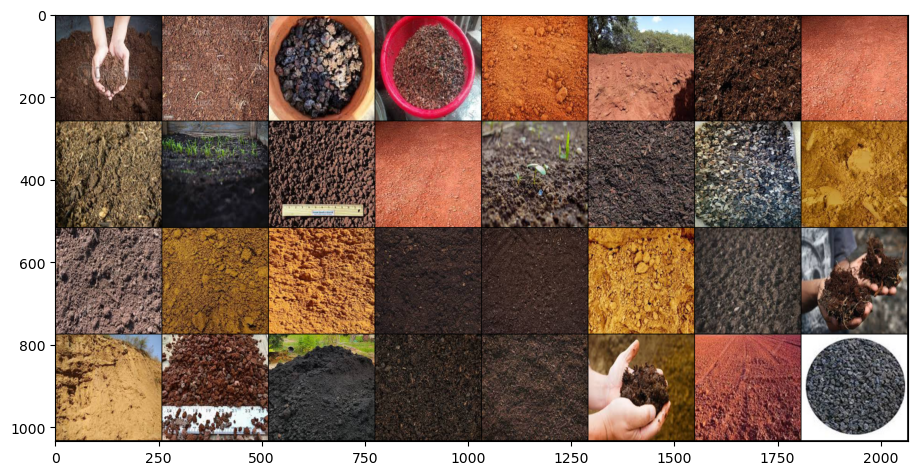

In [5]:
train_loader, val_loader = prepare_and_get_loaders()
X_train, Y_train = get_imgs(train_loader)
X_val, Y_val = get_imgs(val_loader)
show_images(train_loader)

## Part 2: Nearest Neighbors Approach

In the second part of the assignment, you will do the following:

• Feature extraction (15 points). Find a pretrained CNN model (e.g. ResNet) and use the
penultimate layer activations as a feature representation. Your jupyter notebook should
include code that demonstrates how to use the pretrained model to extract features
from an image in the dataset.


• Nearest Neighbor Method (15 points). Extract features from all the images in the
training set and store them in a single file along with the building labels. For each image
in the validation set, use the pretrained CNN model to extract the feature
representation, calculate which training image is closest in Euclidean distance, and use
its label as the prediction. Report your classification accuracy.

In [6]:
def load_resnet():
    """
    
    Loads a pretrained ResNet model. 
    
    """
    
    #Useful Resource: https://stackoverflow.com/questions/52548174/how-to-remove-the-last-fc-layer-from-a-resnet-model-in-pytorch
    model = models.resnet18(weights="ResNet18_Weights.DEFAULT")
    
    #we gotta keep all layers except the last one
    modules = list(model.children())[:-1] 
    model = nn.Sequential(*modules)
    model.eval()
    
    return model

In [12]:
def feature_extraction(model, loader):
    """
    
    Uses a pretrained model and returns the penultimate layer activations 
    as a feature representation. 
    
    This code demonstrates how to use a pretrained model to extract features from an image in the dataset
    
    """
    features_list = []
    labels_list = []
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    with torch.no_grad(): #No Training
        for inputs, labels in tqdm(loader, desc="Extracting: "):
            inputs.to(device)
            feature = model(inputs) 
            feature.flatten(start_dim=1)
            features_list.append(feature)
            labels_list.append(labels)
    
    #put the features all togehter
    features = torch.cat(features_list, dim=0)
    labels = torch.cat(labels_list, dim=0)
    
    return features, labels

In [33]:
def nearest_neighbors(X_train_features, Y_train, data_features):
    """
    
    Here, we calculate which training image is closest in Euclidean distance to each given validation image,
    and we use that to label the training image. 
    
    """
    
    labels = []
    for feature in data_features:
        distances = torch.sqrt(torch.sum((X_train_features - feature)**2, dim=1))
        index = torch.argmin(distances).item()
        labels.append(int(Y_train[index]))

    return np.array(labels)

In [34]:
model = load_resnet()
train_loader, val_loader = prepare_and_get_loaders()
X_train_features, Y_train = feature_extraction(model, train_loader)
X_val_features, Y_val = feature_extraction(model, val_loader)
val_labels = nearest_neighbors(X_train_features, Y_train, X_val_features)

Y_val = np.array(Y_val)
accuracy = 100 * np.mean(val_labels==Y_val)
print(f"Our classification accuracy using a nearest-single-neighbor approach is {accuracy:.2f}%")

Extracting: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.14s/it]

Our classification accuracy using a nearest-single-neighbor approach is 65.22%


## Part 3: Fine-tuning Approach

In the third part of the assignment, you will do the following:


• Finetuning (25 points). Remove the output layer of the pretrained CNN model and
replace it with a randomly initialized output layer that classifies among the 5 buildings of
interest. Finetune the modified model on the training samples. Include your
training/validation loss curves in your notebook, along with the final validation
classification accuracy.


• Improvements (10 points). Experiment with different ways to improve the validation
accuracy. Include any results or figures to document your progress.


In [39]:
def load_random_resnet():
    """
    
    Loads a pretrained ResNet model, but with the final output layer removed and replaced with a randomly 
    initialized output layer that will classify among the 5 buildings. 
    
    """
    
    model = models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    
    #Replace the last FC layer so that it'll have 5 classes
    model.fc = nn.Linear(num_ftrs, 5)
    
    return model

In [51]:
def finetune(model, train_loader, val_loader, learning_rate, num_epochs):
    """
    
    Trains the given model on the X_train and Y_train data, and returns the trained model as well as the losses
    and final validation accuracy.
    
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    #https://pytorch.org/docs/stable/generated/torch.optim.Adam.html
    optimizer = optim.Adam(model.parameters(), lr=learning_rate) #me and my homies love Adam
    
    hist = {'train': [], 'val': []} # History of training and validation losses
    
    for epoch in tqdm(range(num_epochs), desc = "Training Epoch: "):
        model.train() #Training mode
        total_loss = 0.0
        for inputs, labels in train_loader:
            #put stuff on device
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            #zero optimizer
            optimizer.zero_grad()
            
            #get outputs + train
            outputs = model(inputs)
            
            #get loss and do backward 
            loss = criterion(outputs, labels)
            loss.backward()
            
            #step
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_train_loss = total_loss / len(train_loader)
        hist['train'].append(avg_train_loss)
        
        #Validation Mode Now
        model.eval()
        total_loss = 0.0
        
        #keep track of correct labels so we can get the val accuracy
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                #put on device
                inputs.to(device)
                labels.to(device)

                #get outputs
                outputs = model(inputs)
                
                #get loss
                loss = criterion(outputs, labels)
                total_loss += loss.item()
                
                #https://www.digitalocean.com/community/tutorials/pytorch-torch-max
                max_element, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = total_loss / len(val_loader)
        hist['val'].append(avg_val_loss)
        val_accuracy = 100 * correct / total
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
        
    #final val accuracy
    final_val_accuracy = 100*correct/total
    
    return model, hist, final_val_accuracy

In [52]:
learning_rate = 0.0001
num_epochs = 5
part3_model = load_random_resnet()
train_loader, val_loader = prepare_and_get_loaders()
part3_model = load_random_resnet()
model, hist, final_val_accuracy = finetune(part3_model, train_loader, val_loader, learning_rate, num_epochs)
print(f"Our final validation accuracy accuracy using the full CNN is {final_val_accuracy:.2f}%")

Training Epoch:  20%|█████████████▌                                                      | 1/5 [00:15<01:03, 15.92s/it]

Epoch [1/5], Training Loss: 1.4206, Validation Loss: 1.4807, Validation Accuracy: 36.96%


Training Epoch:  40%|███████████████████████████▏                                        | 2/5 [00:31<00:47, 15.75s/it]

Epoch [2/5], Training Loss: 0.4685, Validation Loss: 1.1911, Validation Accuracy: 63.04%


Training Epoch:  60%|████████████████████████████████████████▊                           | 3/5 [00:47<00:31, 15.76s/it]

Epoch [3/5], Training Loss: 0.2083, Validation Loss: 0.9223, Validation Accuracy: 73.91%


Training Epoch:  80%|██████████████████████████████████████████████████████▍             | 4/5 [01:03<00:15, 15.93s/it]

Epoch [4/5], Training Loss: 0.0894, Validation Loss: 0.6610, Validation Accuracy: 82.61%


Training Epoch: 100%|████████████████████████████████████████████████████████████████████| 5/5 [01:20<00:00, 16.16s/it]

Epoch [5/5], Training Loss: 0.0424, Validation Loss: 0.5852, Validation Accuracy: 82.61%
Our final validation accuracy accuracy using the full CNN is 82.61%


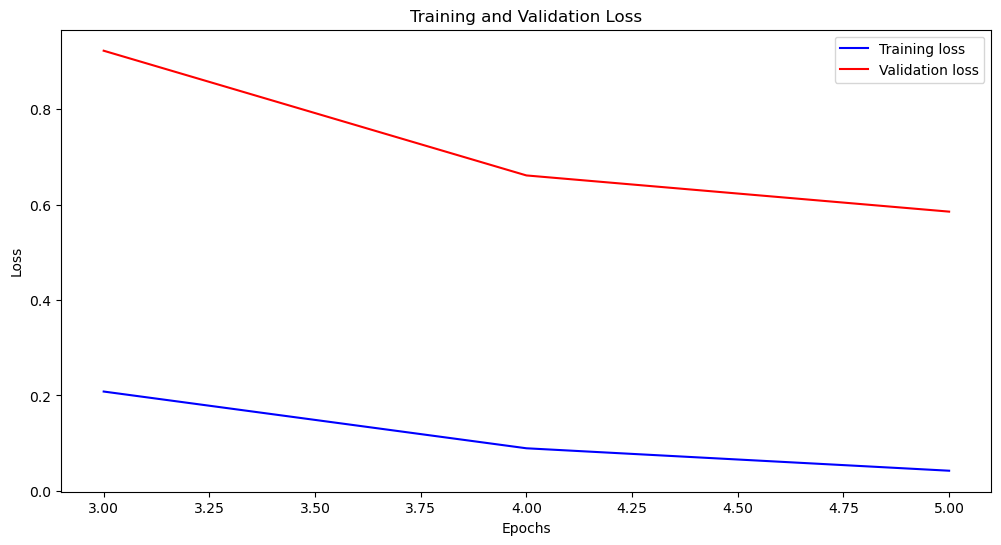

In [53]:
def plot_history(hist):
    epochs = range(1, len(hist['train']) + 1)

    # Plot training and validation loss
    plt.figure(figsize=(12, 6))
    plt.plot(epochs[2:], hist['train'][2:], 'b', label='Training loss')
    plt.plot(epochs[2:], hist['val'][2:], 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(hist)

## Below are some of the different ways we experimented with to improve accuracy. 

### Below I show the results of the augmentation approach. Using this method, we were able to improve the accuracy by _%. 

In [55]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)


def prepare_and_get_loaders_augmentation():
    """
    This function loads and partitions our image data.
    """
    validation_split = 0.25 #play with this
    batch_size = 32 #play with this
    num_workers = 0 #increasing this number makes it go faster - multiprocessing
    
    dir_path = "Datasets/Soil Types" #path
    
    #Applying different transform to each dataset, helpful resource:
    #https://stackoverflow.com/questions/75010445/pytorch-apply-different-transform-to-dataset-after-creation
    #https://discuss.pytorch.org/t/changing-transformation-applied-to-data-during-training/15671

    data_transforms = {
        'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(30),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # Adjust RGB mean, std!
    ]),

        'test': transforms.Compose([
            transforms.Resize((256,256)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # Adjust RGB mean, std!
        ])
    }
    full_dataset = datasets.ImageFolder(dir_path)

    m = len(full_dataset)
    val_size = int(validation_split * m)
    train_size = m - val_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
    
    train_dataset = MyDataset(train_dataset, transform=data_transforms['train'])
    val_dataset = MyDataset(val_dataset, transform=data_transforms['test'])
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    return train_loader, val_loader

In [57]:
learning_rate = 0.0001
num_epochs = 5

part3_model = load_random_resnet()

train_loader, val_loader = prepare_and_get_loaders_augmentation()
part3_model = load_random_resnet()
model, hist, final_val_accuracy = finetune(part3_model, train_loader, val_loader, learning_rate, num_epochs)


print(f"Our final validation accuracy accuracy using the full CNN is {final_val_accuracy:.2f}%")

Training Epoch:  20%|█████████████▌                                                      | 1/5 [00:12<00:49, 12.26s/it]

Epoch [1/5], Training Loss: 1.6013, Validation Loss: 1.2507, Validation Accuracy: 56.41%


Training Epoch:  40%|███████████████████████████▏                                        | 2/5 [00:24<00:36, 12.20s/it]

Epoch [2/5], Training Loss: 0.9518, Validation Loss: 0.8336, Validation Accuracy: 87.18%


Training Epoch:  60%|████████████████████████████████████████▊                           | 3/5 [00:36<00:24, 12.19s/it]

Epoch [3/5], Training Loss: 0.6829, Validation Loss: 0.5612, Validation Accuracy: 87.18%


Training Epoch:  80%|██████████████████████████████████████████████████████▍             | 4/5 [00:48<00:12, 12.19s/it]

Epoch [4/5], Training Loss: 0.5022, Validation Loss: 0.4520, Validation Accuracy: 92.31%


Training Epoch: 100%|████████████████████████████████████████████████████████████████████| 5/5 [01:00<00:00, 12.20s/it]

Epoch [5/5], Training Loss: 0.4204, Validation Loss: 0.3454, Validation Accuracy: 92.31%
Our final validation accuracy accuracy using the full CNN is 92.31%


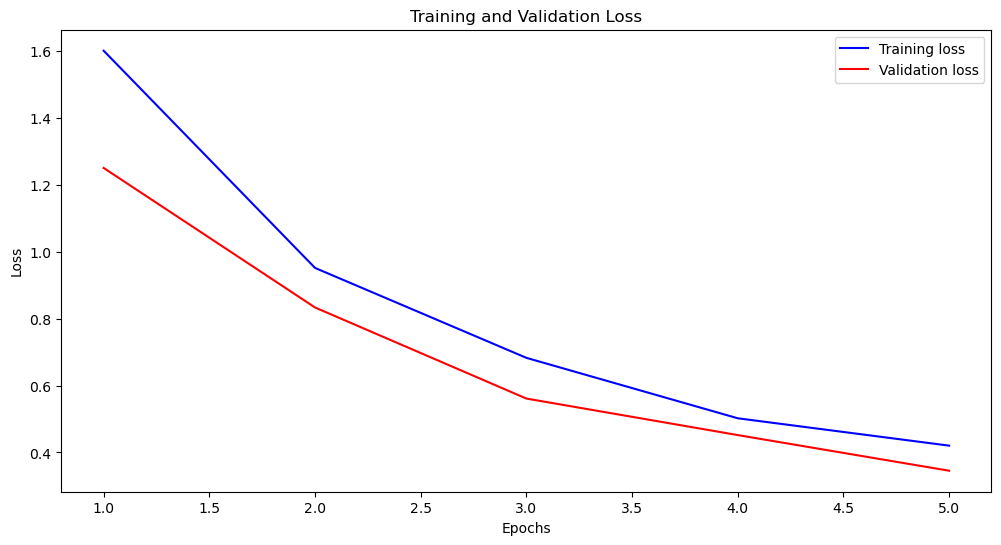

In [58]:
def plot_history(hist):
    epochs = range(1, len(hist['train']) + 1)

    # Plot training and validation loss
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, hist['train'], 'b', label='Training loss')
    plt.plot(epochs, hist['val'], 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(hist)